In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet50
from keras.applications import vgg16
from keras.applications import inception_v3
from keras.src.applications.vgg16 import VGG16

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter


In [ ]:
# data_dir = '/content/drive/MyDrive/Đồ án AI/Data/The IQ-OTHNCCD lung cancer dataset/begin'

# categories = ['begin', 'malignants', 'normal']

# def preprocess_image(file_path):
#     img = cv2.imread(file_path, 0)
#     # img = cv2.resize(img, (224, 224))
#     img = img / 255.0  # Chuẩn hóa pixel trong khoảng [0, 1]
#     return img

In [ ]:
# img=preprocess_image(os.path.join(data_dir,'Bengin case (10).jpg'))
# plt.imshow(img,cmap='gray')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# data_dir = '/content/drive/MyDrive/Đồ án AI/Data/The IQ-OTHNCCD lung cancer dataset'
data_dir = '/content/drive/MyDrive/Data/The IQ-OTHNCCD lung cancer dataset'

categories = ['begin', 'malignants', 'normal']

def preprocess_image(file_path):
    img = cv2.imread(file_path, 0)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Chuẩn hóa pixel trong khoảng [0, 1]
    return img

data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        img = preprocess_image(file_path)
        data.append(img)
        labels.append(label)

data, labels = shuffle(data, labels, random_state=42)

# Kiểm tra cân bằng dữ liệu
print('Data length:', len(data))
print('labels counts:', Counter(labels))

# normalize
X = np.array(data).reshape(-1, 224, 224, 1)
X=X/255.0
y = np.array(labels)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data/The IQ-OTHNCCD lung cancer dataset/begin'

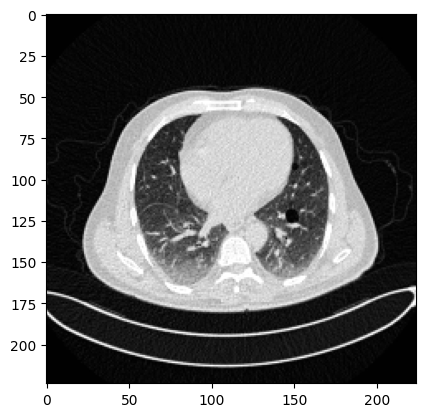

In [ ]:
plt.imshow(X[0],cmap='gray')

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=10)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 822 (822, 224, 224, 1)
Test length: 275 (275, 224, 224, 1)


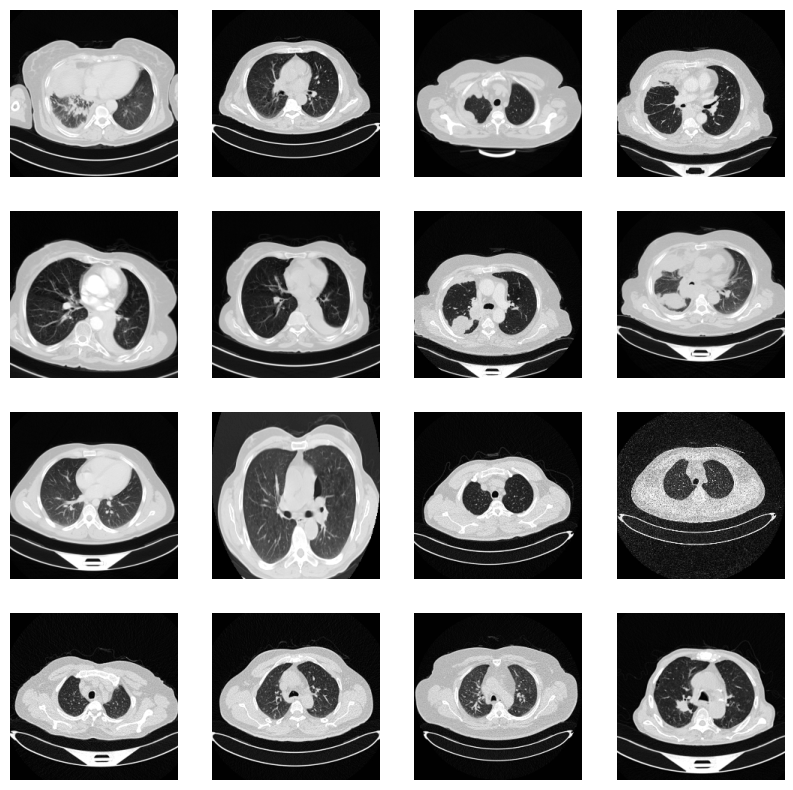

In [ ]:
# data_generator=ImageDataGenerator()

# for X_batch,y_batch in data_generator.flow(X_train,y_train,batch_size=16,shuffle=False):
#   fig,ax=plt.subplots(4,4,figsize=(10,10))
#   for i in range(4):
#     for j in range(4):
#       ax[i][j].axis('off')
#       ax[i][j].imshow(X_batch[i*4+j].reshape(224,224),cmap='gray')
#   plt.show()
#   break

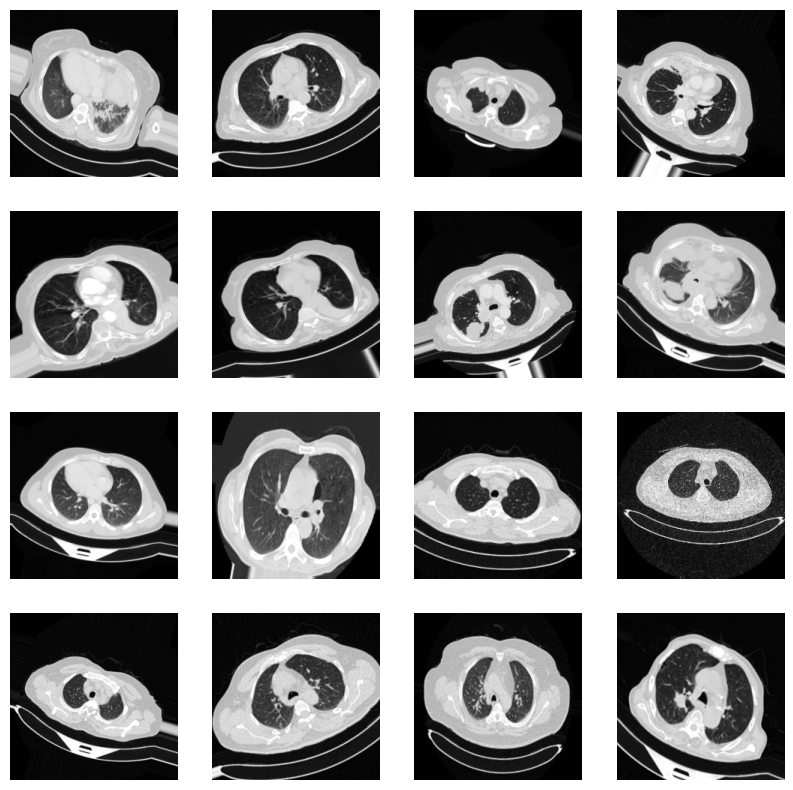

In [ ]:
# data_generator=ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=30,
#     zoom_range=0.2,
#     shear_range=0.2,
#     horizontal_flip=0.5
# )

# for X_batch,y_batch in data_generator.flow(X_train,y_train,batch_size=16,shuffle=False):
#   fig,ax=plt.subplots(4,4,figsize=(10,10))
#   for i in range(4):
#     for j in range(4):
#       ax[i][j].axis('off')
#       ax[i][j].imshow(X_batch[i*4+j].reshape(224,224),cmap='gray')
#   plt.show()
#   break

In [ ]:
# data_generator=ImageDataGenerator(
#     rescale=1./255,
#     width_shift_range=0.2,
#     height_shift_range=0.3
# )
# training_set = data_generator.flow(X_train, y_train, batch_size=16, shuffle=True)


# val_datagen = ImageDataGenerator()
# validation_set = val_datagen.flow(X_valid, y_valid, batch_size=16, shuffle=True)

In [ ]:
# Check data balance in the training set
train_class_counts = Counter(y_train)
print("Number of samples for each class in the training set:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} samples")

# Check data balance in the validation set
valid_class_counts = Counter(y_valid)
print("\nNumber of samples for each class in the validation set:")
for class_label, count in valid_class_counts.items():
    print(f"Class {class_label}: {count} samples")

Number of samples for each class in the training set:
Class 2: 323 samples
Class 1: 414 samples
Class 0: 85 samples

Number of samples for each class in the validation set:
Class 2: 93 samples
Class 1: 147 samples
Class 0: 35 samples


In [ ]:
# The code computes class weights (class_weights) to handle imbalanced data during model training.
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [ ]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=16, shuffle=True)
validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=16, shuffle=True)

In [ ]:
# X_train.shape[1:]

(224, 224, 1)

In [ ]:
vgg = VGG16(weights=None, include_top=False, input_shape=X_train.shape[1:])

# Freeze the pre-trained layers so they are not updated during training
for layer in vgg.layers:
    layer.trainable = False



X=Flatten()(vgg.output)
X = Dense(256, activation='relu')(X)
prediction=Dense(3,activation="softmax")(X)
model_vgg=Model(inputs=vgg.input,outputs=prediction)

model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
resnet_base = ResNet50(weights=None, include_top=False,  input_shape=X_train.shape[1:])

# Freeze the pre-trained layers so they are not updated during training
for layer in resnet_base.layers:
    layer.trainable = False

model_resnet = Sequential()


model_resnet.add(resnet_base)

model_resnet.add(Flatten())
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dense(3, activation='softmax'))

model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23581440  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               12845184  
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 36427011 (138.96 MB)
Trainable params: 12845571 (49.00 MB)
Non-trainable params: 23581440 (89.96 MB)
_________________________________________________________________


In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
model_resnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model_resnet.fit(train_generator, epochs=160, validation_data=validation_generator, callbacks=[callback])

Epoch 1/160
52/52 [==============================] - 5s 89ms/step - loss: 0.6585 - accuracy: 0.7421 - val_loss: 0.6880 - val_accuracy: 0.7164
Epoch 2/160
52/52 [==============================] - 4s 79ms/step - loss: 0.6454 - accuracy: 0.7616 - val_loss: 0.6853 - val_accuracy: 0.7273
Epoch 3/160
52/52 [==============================] - 4s 77ms/step - loss: 0.6374 - accuracy: 0.7652 - val_loss: 0.6714 - val_accuracy: 0.7309
Epoch 4/160
52/52 [==============================] - 4s 76ms/step - loss: 0.6193 - accuracy: 0.7640 - val_loss: 0.6591 - val_accuracy: 0.7200
Epoch 5/160
52/52 [==============================] - 4s 82ms/step - loss: 0.6079 - accuracy: 0.7713 - val_loss: 0.6562 - val_accuracy: 0.7382
Epoch 6/160
52/52 [==============================] - 4s 76ms/step - loss: 0.5998 - accuracy: 0.7701 - val_loss: 0.6380 - val_accuracy: 0.7455
Epoch 7/160
52/52 [==============================] - 4s 76ms/step - loss: 0.5873 - accuracy: 0.7786 - val_loss: 0.6281 - val_accuracy: 0.7455
Epoch 

In [ ]:
model_vgg.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_vgg = model_vgg.fit(train_generator, epochs=40, validation_data=validation_generator, callbacks=[callback])

Epoch 1/40
52/52 [==============================] - 16s 208ms/step - loss: 1.0566 - accuracy: 0.4538 - val_loss: 1.0155 - val_accuracy: 0.5345
Epoch 2/40
52/52 [==============================] - 5s 88ms/step - loss: 0.9705 - accuracy: 0.5036 - val_loss: 0.9699 - val_accuracy: 0.5345
Epoch 3/40
52/52 [==============================] - 5s 87ms/step - loss: 0.9481 - accuracy: 0.5036 - val_loss: 0.9726 - val_accuracy: 0.5345
Epoch 4/40
52/52 [==============================] - 5s 90ms/step - loss: 0.9477 - accuracy: 0.5036 - val_loss: 0.9725 - val_accuracy: 0.5345
Epoch 5/40
52/52 [==============================] - 5s 87ms/step - loss: 0.9480 - accuracy: 0.5036 - val_loss: 0.9706 - val_accuracy: 0.5345
Epoch 6/40
52/52 [==============================] - 5s 88ms/step - loss: 0.9493 - accuracy: 0.5036 - val_loss: 0.9722 - val_accuracy: 0.5345
Epoch 7/40
52/52 [==============================] - 5s 89ms/step - loss: 0.9481 - accuracy: 0.5036 - val_loss: 0.9689 - val_accuracy: 0.5345
Epoch 8/40


In [ ]:
def AlexNet(input_shape=(224,224,1)):
        inp = Input(input_shape)
        # 1st Convolutional Layer
        x = Conv2D(96,11,4, activation='relu', padding='valid',kernel_initializer='he_normal')(inp)
        # Max Pooling
        x = MaxPooling2D(3,2)(x)
        # 2st Convolutional Layer
        x = Conv2D(256,5,1, activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # Max Pooling
        x = MaxPooling2D(3,2)(x)
        # 3st Convolutional Layer
        x = Conv2D(384,3,1,activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # 4st Convolutional Layer
        x = Conv2D(384,3,1,activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # 5st Convolutional Layer
        x = Conv2D(256,3,1,activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # Max Pooling
        x = MaxPooling2D(3,2)(x)
        # Passing it to a Fully Connected layer
        x = Flatten()(x)
        # 1st fully connected layer has 4096 neurons
        x = Dense(4096, activation='relu')(x)
        # Add Dropout to prevent overfitting
        x = Dropout(0.5)(x)
        # 2nd fully connected layer
        x = Dense(4096, activation='relu')(x)
        # Add droupout
        x = Dropout(0.5)(x)
        # Output layer
        x = Dense(3, activation='softmax')(x)

        model = Model(inputs=inp, outputs=x)
        return model

model_alex = AlexNet()
model_alex.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 384)         8851

In [ ]:
model_alex.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_alex = model_alex.fit(training_set, epochs=20, validation_data=validation_set, callbacks=[callback])

Epoch 1/20
52/52 [==============================] - 9s 84ms/step - loss: 0.9775 - accuracy: 0.4903 - val_loss: 0.9842 - val_accuracy: 0.5345
Epoch 2/20
52/52 [==============================] - 4s 69ms/step - loss: 0.9627 - accuracy: 0.4757 - val_loss: 0.9744 - val_accuracy: 0.5345
Epoch 3/20
52/52 [==============================] - 4s 68ms/step - loss: 0.9538 - accuracy: 0.4878 - val_loss: 0.9777 - val_accuracy: 0.5345
Epoch 4/20
52/52 [==============================] - 5s 89ms/step - loss: 0.9574 - accuracy: 0.4830 - val_loss: 0.9738 - val_accuracy: 0.5345
Epoch 5/20
52/52 [==============================] - 5s 86ms/step - loss: 0.9570 - accuracy: 0.4964 - val_loss: 0.9725 - val_accuracy: 0.5345
Epoch 6/20
52/52 [==============================] - 4s 69ms/step - loss: 0.9524 - accuracy: 0.5024 - val_loss: 0.9707 - val_accuracy: 0.5345
Epoch 7/20
52/52 [==============================] - 4s 67ms/step - loss: 0.9582 - accuracy: 0.4988 - val_loss: 0.9671 - val_accuracy: 0.5345
Epoch 8/20
52

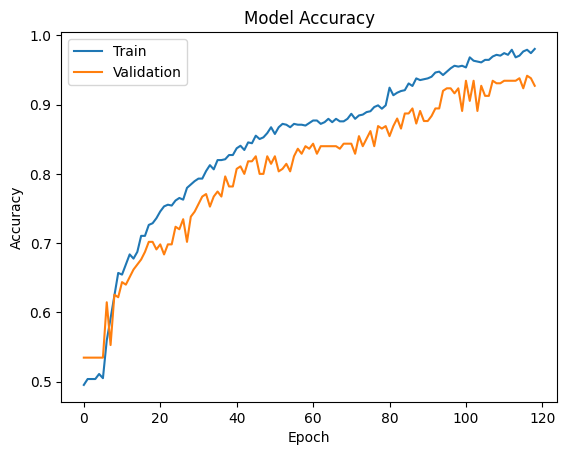

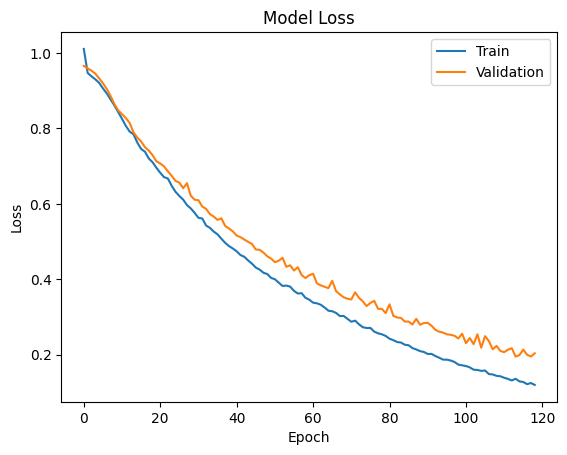

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

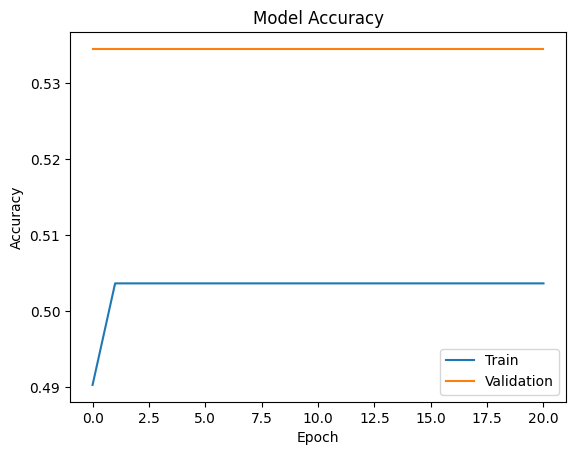

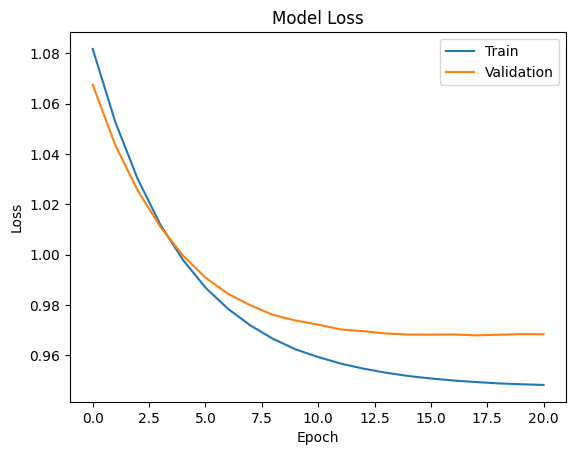

In [ ]:
plt.plot(history_vgg.history['accuracy'], label='Train')
plt.plot(history_vgg.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history_vgg.history['loss'], label='Train')
plt.plot(history_vgg.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred2 = model.predict(X_valid, verbose=1)
y_pred_bool2 = np.argmax(y_pred2, axis=1)

print(classification_report(y_valid, y_pred_bool2))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool2))